# Biến đổi đường Hough

1. Biến đổi đường Hough là một phép biến đổi được sử dụng để phát hiện các đường thẳng.
2. Để áp dụng phép biến đổi, trước tiên cần xử lý trước để phát hiện cạnh.

## Mục tiêu

Trong hướng dẫn này, bạn sẽ học cách:
- Sử dụng các hàm OpenCV `HoughLines()` và `HoughLinesP()` để phát hiện các đường trong hình ảnh.

#### Nó hoạt động như nào?
1. Như bạn đã biết, một đường thẳng trong không gian ảnh có thể được biểu diễn bằng hai biến. Ví dụ:  
    a. Trong hệ tọa độ Descartes: Tham số: $(m,b)$  
    b. Trong hệ tọa độ cực: Tham số: $(r, \theta)$

![image](https://docs.opencv.org/4.x/Hough_Lines_Tutorial_Theory_0.jpg)

Đối với Biến đổi Hough, chúng ta sẽ biểu diễn các đường thẳng trong hệ thống Polar. Do đó, một phương trình đường thẳng có thể được viết như sau:
$$ y = \frac{-cos\theta}{sin\theta}x + \frac{r}{sin\theta} $$
$$ r = x cos\theta + y sin\theta$$

1. Nhìn chung, đối với mỗi điểm $(x_0, y_0)$ , chúng ta có thể định nghĩa họ các đường thẳng đi qua điểm đó như sau:
$$ r_\theta = x_0 cos\theta + y_0 sin\theta$$  
> Nghĩa là mỗi cặp $(r_\theta,\theta)$
đại diện cho mỗi đường thẳng đi qua $(x_0, y_0)$

2. Nếu đối với một $(x_0,y_0)$ cho trước, chúng ta vẽ họ các đường thẳng đi qua nó, chúng ta sẽ có một đường sin. Ví dụ, đối với $x_0 = 8$ và $y_0 = 6$, chúng ta sẽ có đồ thị sau (trong một mặt phẳng $\theta$-$r$):

![image](https://docs.opencv.org/4.x/Hough_Lines_Tutorial_Theory_1.jpg)

Chúng ta chỉ xem xét các điểm sao cho $r>0$ và $0<\theta<2\pi$

1. Chúng ta có thể thực hiện cùng thao tác ở trên cho tất cả các điểm trong một hình ảnh. Nếu các đường cong của hai điểm khác nhau giao nhau trong mặt phẳng $r-\theta$, điều đó có nghĩa là cả hai điểm đều thuộc cùng một đường thẳng. Ví dụ, theo ví dụ ở trên và vẽ đồ thị cho hai điểm nữa: $x_1 = 4$, $y_1 = 9$ và
$x_2 = 12$, $y_2 = 3$, chúng ta có:

![](https://docs.opencv.org/4.x/Hough_Lines_Tutorial_Theory_2.jpg)

Ba biểu đồ giao nhau tại một điểm duy nhất $(0.925, 9.6)$, các tọa độ này là các tham số $(\theta,r)$ hoặc đường thẳng mà $(x_0,y_0)$, $(x_1, y_1)$ và $(x_2,y_2)$ nằm trên đó.

1. Tất cả những điều trên có nghĩa là gì? Nghĩa là nói chung, một đường thẳng có thể được phát hiện bằng cách tìm số giao điểm giữa các đường cong. Càng nhiều đường cong giao nhau thì đường thẳng được biểu diễn bởi giao điểm đó có nhiều điểm hơn. Nói chung, chúng ta có thể xác định ngưỡng số lượng giao điểm tối thiểu cần thiết để phát hiện một đường thẳng.
2. Đây chính là những gì Hough Line Transform thực hiện. Nó theo dõi giao điểm giữa các đường cong của mọi điểm trong hình ảnh. Nếu số lượng giao điểm vượt quá một ngưỡng nào đó, thì nó sẽ khai báo đó là một đường thẳng có các tham số $(\theta,r_\theta)$ của điểm giao nhau.

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

src = cv2.imread("images/chessboard.jpg", cv2.IMREAD_GRAYSCALE)
# src = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 5)
dst = cv2.Canny(src, 50, 200, None, 3)

### Biến đổi Hough chuẩn

- Nó bao gồm khá nhiều những gì chúng ta vừa giải thích ở phần trước. Nó cung cấp cho bạn kết quả là một vector các cặp $(\theta, r_\theta)$
- Trong OpenCV, nó được triển khai bằng hàm `HoughLines()`
#### Cú pháp hàm
```python
lines = cv2.HoughLines(image, rho, theta, threshold[, lines[, srn[, stn[, min_theta[, max_theta]]]]])
```
Hàm có **4 đối số bắt buộc**:
1. `image`: Ảnh đầu vào (ảnh nhị phân, thường là kết quả của edge detection, kiểu numpy array).
2. `rho`: Độ phân giải của tham số $r$ (rho) tính bằng pixel.
3. `theta`: Độ phân giải của tham số góc theta tính bằng radian.
4. `threshold`: Ngưỡng tích lũy (số lượng điểm ảnh tối thiểu trên một đường để được xem là một đường thẳng).

Giải thích: 
- `lines`: Mảng đầu ra chứa các đường phát hiện được (tùy chọn).
- `srn`, `stn`: Các tham số cho phương pháp đa tỷ lệ (tùy chọn).
- `min_theta`, `max_theta`: Giới hạn góc theta (tùy chọn).

Kết quả trả về:
- `lines`: Mảng các đường thẳng phát hiện được, mỗi đường được biểu diễn bởi cặp $(r, \theta)$.

In [15]:
cdst  = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

### Biến đổi đường Hough xác suất
- Một triển khai hiệu quả hơn của Hough Line Transform. Nó cung cấp đầu ra là các cực trị của các dòng được phát hiện $(x_0, y_0, x_1, y_1)$
- Trong OpenCV, nó được triển khai bằng hàm `HoughLinesP()`

#### Cú pháp hàm 
```python
lines = cv2.HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]])
```
Hàm có 4 đối số bắt buộc:
1. `image`: Ảnh đầu vào (ảnh nhị phân, thường là kết quả của edge detection, kiểu numpy array).
2. `rho`: Độ phân giải của tham số r (rho) tính bằng pixel.
3. `theta`: Độ phân giải của tham số góc theta tính bằng radian.
4. `threshold`: Ngưỡng tích lũy (số lượng điểm ảnh tối thiểu trên một đường để được xem là một đoạn thẳng).

Giải thích:
- `lines`: Mảng đầu ra chứa các đoạn thẳng phát hiện được (tùy chọn).
- `minLineLength`: Độ dài tối thiểu của đoạn thẳng (tùy chọn).
- `maxLineGap`: Khoảng cách tối đa giữa hai điểm trên cùng một đoạn thẳng để được nối thành một đoạn (tùy chọn).

Kết quả trả về:
- `lines`: Mảng các đoạn thẳng phát hiện được, mỗi đoạn được biểu diễn bởi 4 giá trị (x1, y1, x2, y2).

In [16]:
cdstP = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 150, None, 150, 50)
if linesP is not None:
    for line in linesP:
        l = line[0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 8, cv2.LINE_AA)

### Biến đổi Hough có trọng số
- Sử dụng cường độ cạnh thay vì giá trị nhị phân 0 hoặc 1 trong phép biến đổi Hough chuẩn.
- Trong OpenCV, nó được triển khai bằng hàm `HoughLines()` với `use_edgeval=true`.

#### Kết quả

Text(0.5, 1.0, 'Probabilistic')

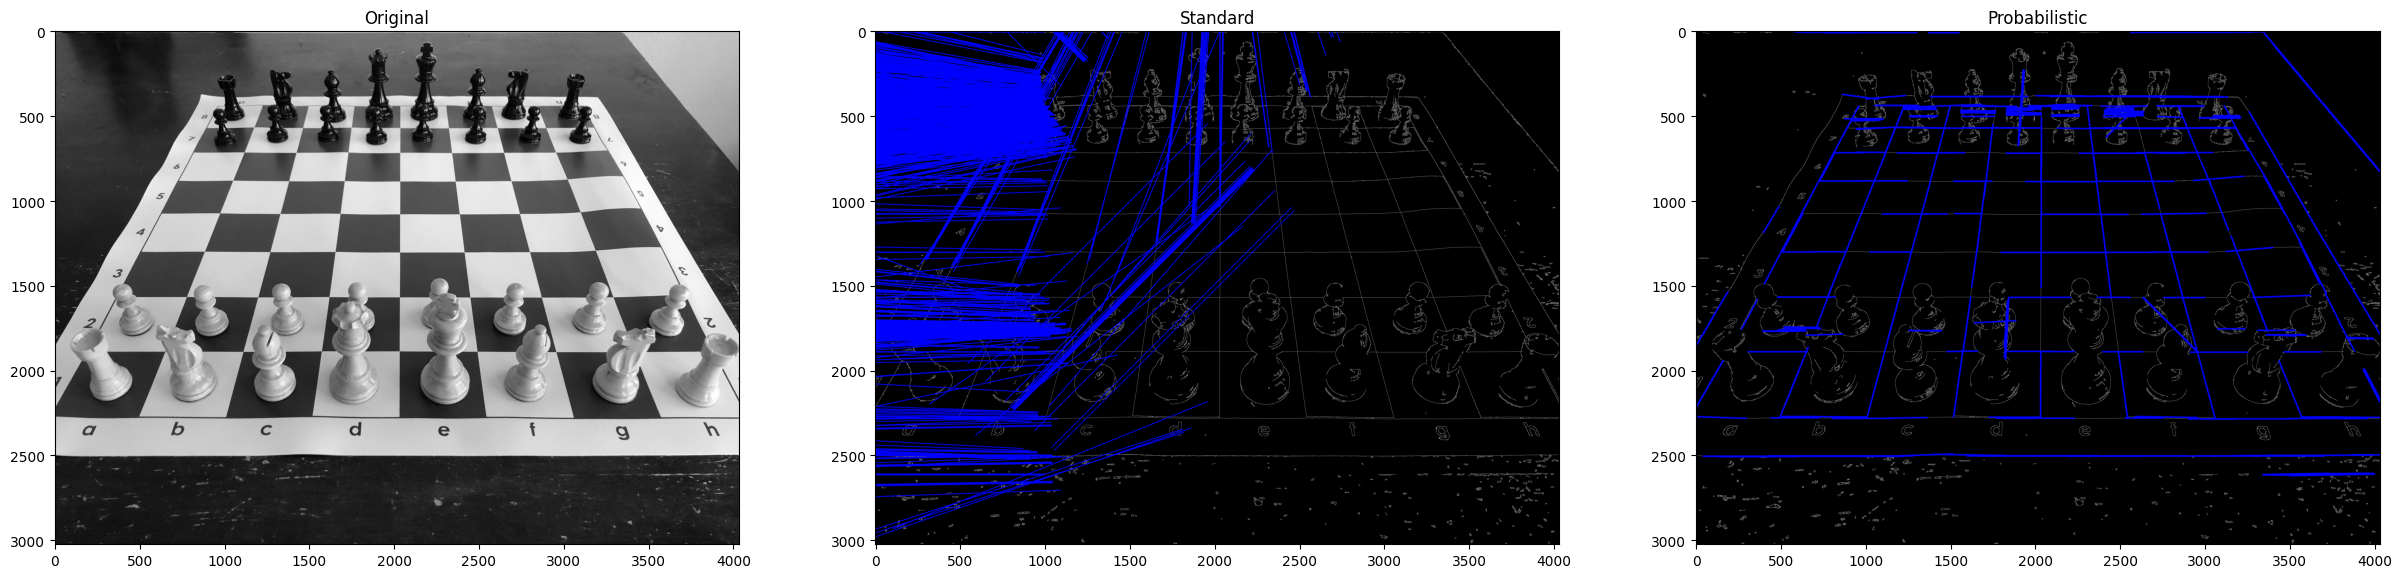

In [17]:
plt.figure(figsize=[30, 10])
plt.subplot(131); plt.imshow(src, cmap="gray");  plt.title("Original")        
plt.subplot(132); plt.imshow(cdst, cmap="gray"); plt.title("Standard")
plt.subplot(133); plt.imshow(cdstP, cmap="gray"); plt.title("Probabilistic")